In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [79]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化
])

# 加载 CIFAR-10 数据集
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=96, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=96, pin_memory=True)

# use GPU if available
for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    break
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    break

Files already downloaded and verified
Files already downloaded and verified


## GAN 网络的生成器和判别器的实现

In [80]:
# 生成器 （GAN）
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [81]:
# 判别器 (GAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [82]:
# 初始化模型
latent_dim = 128
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
epochs = 10

In [88]:
# 加载预训练的GAN
generator.load_state_dict(torch.load('generator.pth', map_location=device, weights_only=False))
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)

In [98]:
# 训练
for epoch in range(epochs):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)  # 将真实图像转移到 GPU
        
        # 训练判别器
        valid = torch.ones(real_imgs.size(0), 1, device=device)  # 正样本标签
        fake = torch.zeros(real_imgs.size(0), 1, device=device)  # 负样本标签

        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)  # 随机噪声
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 训练生成器
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch+1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    

# save model
torch.save(generator.state_dict(), 'generator.pth')

Epoch 1, D Loss: 0.9377143383026123, G Loss: 2.4963889122009277
Epoch 2, D Loss: 1.092598795890808, G Loss: 1.7968122959136963
Epoch 3, D Loss: 1.1511001586914062, G Loss: 3.3047494888305664
Epoch 4, D Loss: 0.6284692883491516, G Loss: 2.977431297302246
Epoch 5, D Loss: 0.6056594848632812, G Loss: 2.4417319297790527
Epoch 6, D Loss: 0.6061239242553711, G Loss: 3.0186290740966797
Epoch 7, D Loss: 0.721441388130188, G Loss: 2.4803967475891113
Epoch 8, D Loss: 0.5899871587753296, G Loss: 2.8706464767456055
Epoch 9, D Loss: 0.6457877159118652, G Loss: 2.8717827796936035
Epoch 10, D Loss: 0.8559664487838745, G Loss: 2.600209951400757


In [101]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        outputs = discriminator(imgs)
        predicted = (outputs > 0.5).float()
        total += imgs.size(0)
        correct += (predicted == torch.ones_like(predicted, device=device)).sum().item()
print(f"Accuracy: {100 * correct / total}%")

Accuracy: 62.34975961538461%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


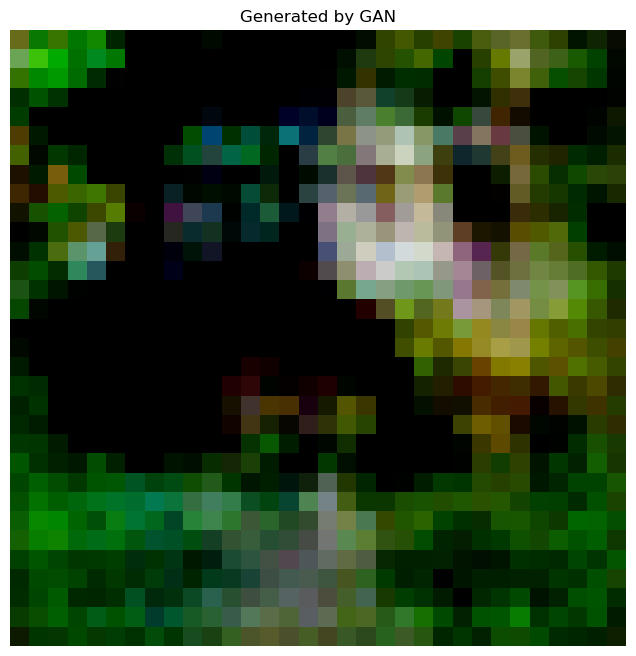

In [103]:
# 保存生成图像 （GAN）
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)  # 噪声在 GPU 上
    samples = generator(z).cpu()  # 将生成的样本转移到 CPU
    save_image(samples, 'gan_samples.png', nrow=8)
    
    # show img
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated by GAN")
    plt.imshow(np.transpose(samples[0], (1, 2, 0)))
    plt.show()

## 下面的部分是 CGAN 条件生成网络的实现

In [92]:
# 生成器 （CGAN）
class CGenerator(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super(CGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        input = torch.cat([z, label_embeds], dim=1)
        return self.model(input)

In [93]:
# 判别器 (CGAN)
class CDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(CDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 32 * 32)
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # 输入通道变为 3+1=4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        label_embeds = self.label_embedding(labels).view(labels.size(0), 1, 32, 32)  # 嵌入标签并调整维度
        input = torch.cat([x, label_embeds], dim=1)  # 拼接图像和标签
        return self.model(input)

In [105]:
# 初始化模型 (CGAN)
latent_dim = 128
num_classes = 10
c_generator = CGenerator(latent_dim, num_classes).to(device)
c_discriminator = CDiscriminator(num_classes).to(device)

c_optimizer_G = optim.Adam(c_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_optimizer_D = optim.Adam(c_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
c_criterion = nn.BCELoss()
epochs = 20

In [95]:
# 加载预训练的GAN
c_generator.load_state_dict(torch.load('c_generator.pth', map_location=device, weights_only=False))
c_generator.eval()

CGenerator(
  (label_embedding): Embedding(10, 128)
  (model): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 4, 4))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)

In [106]:
# CGAN 训练
for epoch in range(epochs):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        
        # 判别器训练
        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)
        
        c_optimizer_D.zero_grad()
        real_loss = c_criterion(c_discriminator(real_imgs, labels), valid)
        
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_labels = torch.randint(0, 10, (real_imgs.size(0),), device=device)
        fake_imgs = c_generator(z, gen_labels)
        fake_loss = c_criterion(c_discriminator(fake_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        c_optimizer_D.step()
        
        # 生成器训练
        c_optimizer_G.zero_grad()
        g_loss = c_criterion(c_discriminator(fake_imgs, gen_labels), valid)
        g_loss.backward()
        c_optimizer_G.step()
        
    print(f"Epoch {epoch+1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# save model
torch.save(c_generator.state_dict(), 'c_generator.pth')    

Epoch 1, D Loss: 0.6737897396087646, G Loss: 2.174079179763794
Epoch 2, D Loss: 1.0550240278244019, G Loss: 1.2335894107818604
Epoch 3, D Loss: 0.9520647525787354, G Loss: 1.6057252883911133
Epoch 4, D Loss: 0.9174785017967224, G Loss: 1.5531127452850342
Epoch 5, D Loss: 1.024113416671753, G Loss: 1.994240641593933
Epoch 6, D Loss: 0.8547458648681641, G Loss: 1.843980073928833
Epoch 7, D Loss: 0.9647749066352844, G Loss: 1.3089807033538818
Epoch 8, D Loss: 0.8805677890777588, G Loss: 2.089484214782715
Epoch 9, D Loss: 0.963149905204773, G Loss: 1.5183509588241577
Epoch 10, D Loss: 1.0884069204330444, G Loss: 1.4811279773712158
Epoch 11, D Loss: 0.7797197103500366, G Loss: 1.3738555908203125
Epoch 12, D Loss: 1.0613819360733032, G Loss: 1.1642310619354248
Epoch 13, D Loss: 1.2693185806274414, G Loss: 2.0751328468322754
Epoch 14, D Loss: 0.8147326707839966, G Loss: 2.4886703491210938
Epoch 15, D Loss: 0.9565726518630981, G Loss: 2.2873268127441406
Epoch 16, D Loss: 1.2217501401901245, G 

In [107]:
# evaluate
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = c_discriminator(imgs, labels)
        predicted = (outputs > 0.5).float()
        total += imgs.size(0)
        correct += (predicted == torch.ones_like(predicted, device=device)).sum().item()
print(f"CGAN Accuracy: {100 * correct / total}%")

CGAN Accuracy: 76.01161858974359%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


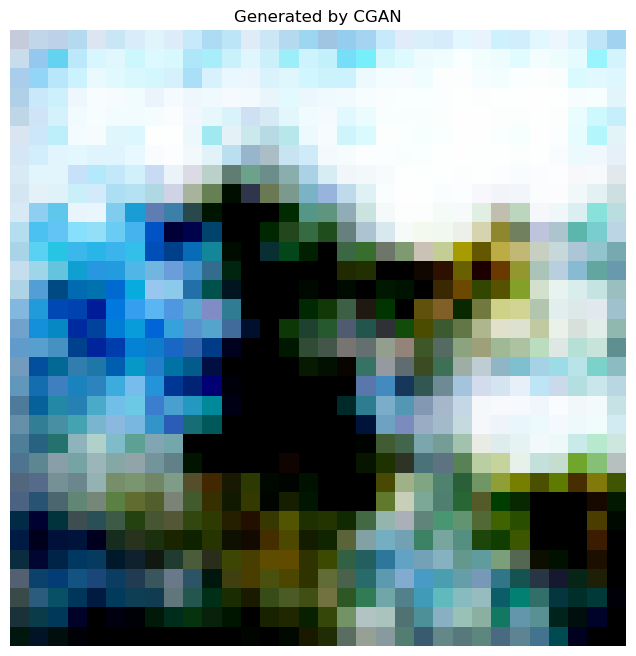

In [109]:
# 保存生成图形（CGAN）
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    labels = torch.arange(10).repeat(7).to(device)[:64]  # 每个类别生成 6 张图片，截取前 64 个标签
    samples = c_generator(z, labels).cpu()
    save_image(samples, 'cgan_samples.png', nrow=10, normalize=True)
    
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated by CGAN")
    plt.imshow(np.transpose(samples[0], (1, 2, 0)))
    plt.show()


# GAN 与 CGAN 生成图像的对比

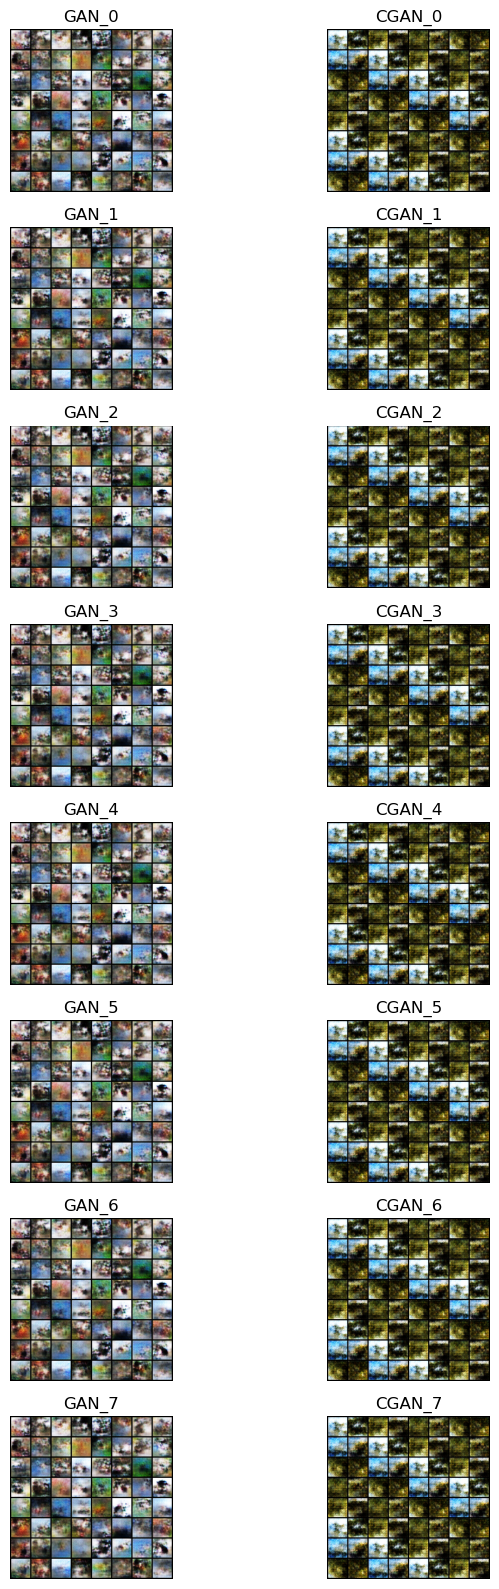

In [111]:
# 展示GAN与CGAN生成的对比图像

# GAN 生成的图像
with torch.no_grad():
    z_gan = torch.randn(64, latent_dim, device=device)
    samples_gan = generator(z_gan).cpu()  # 假设使用的是基础GAN的生成器
    samples_gan = (samples_gan + 1) / 2  # 将 [-1, 1] 转换到 [0, 1]

# CGAN 生成的图像
with torch.no_grad():
    z_cgan = torch.randn(64, latent_dim, device=device)
    labels_cgan = torch.arange(10).repeat(7).to(device)  # 每个类别生成 6 张图片
    samples_cgan = c_generator(z_cgan, labels_cgan[:64]).cpu()
    samples_cgan = (samples_cgan + 1) / 2  # 将 [-1, 1] 转换到 [0, 1]

# 可视化
fig, axes = plt.subplots(8, 2, figsize=(8, 16))
samples_gan = make_grid(samples_gan, nrow=8).permute(1, 2, 0).numpy()
samples_cgan = make_grid(samples_cgan, nrow=8).permute(1, 2, 0).numpy()

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(samples_gan)
        ax.set_title(f"GAN_{int((i+1)/2)}")
    else:
        ax.imshow(samples_cgan)
        ax.set_title(f"CGAN_{int((i-1)/2)}")
    ax.axis("off")

plt.tight_layout()
plt.show()
